In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical

In [2]:
# Step 1: Data Preparation

def load_data():
    # Load KMNIST dataset from tensorflow_datasets
    ds = tfds.load('kmnist', split=['train', 'test'], as_supervised=True, shuffle_files=True)
    train_data, test_data = ds[0], ds[1]

    # Convert to numpy arrays for easy manipulation
    X_train, y_train = [], []
    X_test, y_test = [], []

    for image, label in train_data:
        X_train.append(image.numpy())
        y_train.append(label.numpy())

    for image, label in test_data:
        X_test.append(image.numpy())
        y_test.append(label.numpy())

    return np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)

X_train, y_train, X_test, y_test = load_data()


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/kmnist/incomplete.760AKA_3.0.1/kmnist-train.tfrecord*...:   0%|          |…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/kmnist/incomplete.760AKA_3.0.1/kmnist-test.tfrecord*...:   0%|          | …

Dataset kmnist downloaded and prepared to /root/tensorflow_datasets/kmnist/3.0.1. Subsequent calls will reuse this data.


In [3]:
# Normalize the pixel values to be between 0 and 1
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Flatten the images from 28x28 to 784
X_train = X_train.reshape(-1, 28*28)
X_test = X_test.reshape(-1, 28*28)

# Split the training data further to get an 80% training and 20% validation split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Convert the labels to one-hot encoding
y_train = to_categorical(y_train, 10)
y_val = to_categorical(y_val, 10)
y_test = to_categorical(y_test, 10)

In [7]:
class RBFNetwork:
    def __init__(self, num_centers, input_dim, output_dim):
        self.num_centers = num_centers
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.centers = None
        self.beta = None
        self.weights = None

    def _rbf_function(self, X, center):
        # Gaussian RBF function
        return np.exp(-self.beta * np.linalg.norm(X - center, axis=1)**2)

    def train(self, X, y, learning_rate=0.01, epochs=100):
        # Step 3a: K-means clustering to find RBF centers
        kmeans = KMeans(n_clusters=self.num_centers, random_state=0).fit(X)
        self.centers = kmeans.cluster_centers_

        # Calculate the beta parameter (spread of RBFs)
        d_max = np.max([np.linalg.norm(c1 - c2) for c1 in self.centers for c2 in self.centers])
        self.beta = 1 / (2 * (d_max**2))

        # Initialize weights for the output layer
        self.weights = np.random.randn(self.num_centers, self.output_dim)

        # Step 3b: Train using gradient descent
        for epoch in range(epochs):
            # Compute the output of RBF units
            G = np.zeros((X.shape[0], self.num_centers))
            for i, center in enumerate(self.centers):
                G[:, i] = self._rbf_function(X, center)

            # Compute output of the network
            output = G @ self.weights

            # Numerically stable softmax
            output_max = np.max(output, axis=1, keepdims=True)
            exp_output = np.exp(output - output_max)
            softmax_output = exp_output / np.sum(exp_output, axis=1, keepdims=True)

            # Compute the error
            error = y - softmax_output

            # Update weights
            self.weights += learning_rate * G.T @ error

            # Print loss every 10 epochs
            if epoch % 10 == 0:
                loss = -np.sum(y * np.log(softmax_output + 1e-9)) / X.shape[0]
                print(f"Epoch {epoch}, Loss: {loss}")

    def predict(self, X):
        G = np.zeros((X.shape[0], self.num_centers))
        for i, center in enumerate(self.centers):
            G[:, i] = self._rbf_function(X, center)

        output = G @ self.weights

        # Numerically stable softmax for predictions
        output_max = np.max(output, axis=1, keepdims=True)
        exp_output = np.exp(output - output_max)
        softmax_output = exp_output / np.sum(exp_output, axis=1, keepdims=True)

        return np.argmax(softmax_output, axis=1)

In [8]:
# Step 4: Evaluation
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_true = np.argmax(y_test, axis=1)

    # Accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, cmap='Blues')
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    return accuracy, cm

Epoch 0, Loss: 13.832136877218119
Epoch 10, Loss: 18.66086915136578
Epoch 20, Loss: 18.66086915136578
Epoch 30, Loss: 18.66086915136578
Epoch 40, Loss: 18.66086915136578
Epoch 50, Loss: 17.38823905385528
Epoch 60, Loss: 18.66086915136578
Epoch 70, Loss: 18.66086915136578
Epoch 80, Loss: 18.62719384437912
Epoch 90, Loss: 18.62719384437912
Test Accuracy: 9.98%


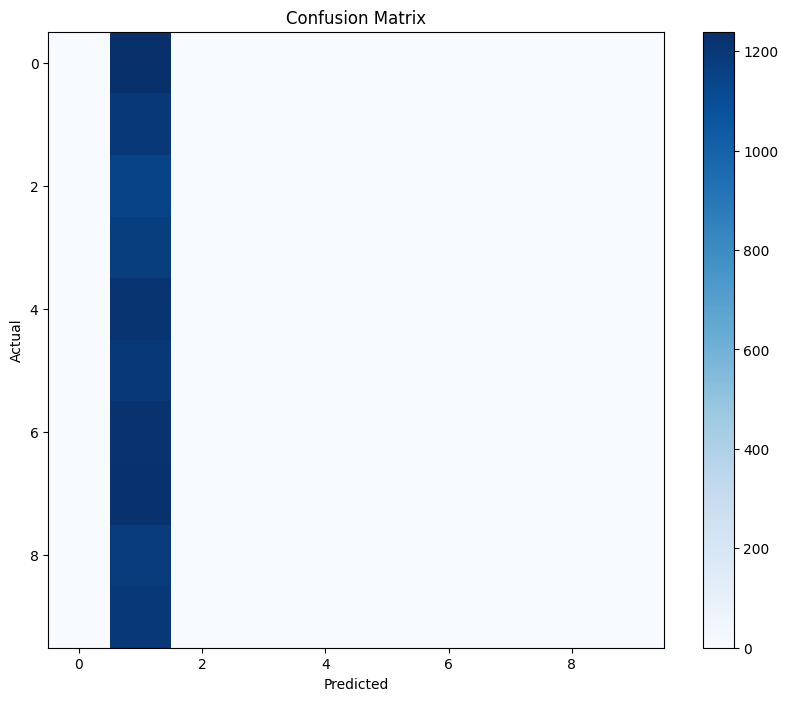

(0.09983333333333333,
 array([[   0, 1239,    0,    0,    0,    0,    0,    0,    0,    0],
        [   0, 1198,    0,    0,    0,    0,    0,    0,    0,    0],
        [   0, 1145,    0,    0,    0,    0,    0,    0,    0,    0],
        [   0, 1175,    0,    0,    0,    0,    0,    0,    0,    0],
        [   0, 1218,    0,    0,    0,    0,    0,    0,    0,    0],
        [   0, 1197,    0,    0,    0,    0,    0,    0,    0,    0],
        [   0, 1223,    0,    0,    0,    0,    0,    0,    0,    0],
        [   0, 1225,    0,    0,    0,    0,    0,    0,    0,    0],
        [   0, 1183,    0,    0,    0,    0,    0,    0,    0,    0],
        [   0, 1197,    0,    0,    0,    0,    0,    0,    0,    0]]))

In [9]:
# Create RBF network with 100 centers (RBF units)
rbf_net = RBFNetwork(num_centers=100, input_dim=784, output_dim=10)

# Train the RBF Network
rbf_net.train(X_train, y_train, learning_rate=0.01, epochs=100)

# Evaluate on the validation set
evaluate_model(rbf_net, X_val, y_val)

In [10]:
# Step 5: Analysis

print("Strengths: RBF networks can approximate complex functions well with fewer parameters.")
print("Limitations: They can be sensitive to the choice of RBF centers and the number of units.")

# Effect of the number of RBF units on performance
print("Increasing the number of RBF units improves accuracy but may lead to overfitting.")

Strengths: RBF networks can approximate complex functions well with fewer parameters.
Limitations: They can be sensitive to the choice of RBF centers and the number of units.
Increasing the number of RBF units improves accuracy but may lead to overfitting.
